In [37]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import robust_scale
from sqlalchemy import create_engine

In [38]:
from castor import spec2sqr, SPECDIR
from spectres import spectres

In [39]:
from ipywidgets import IntProgress
from IPython.display import display

In [44]:
%matplotlib inline
plt.style.use("seaborn-darkgrid")
plt.rcParams["figure.figsize"] = (16, 9)
plt.rcParams["image.cmap"] = "Spectral"

## Data

In [41]:
eng = create_engine("sqlite:///pollux.db")
key = ["Teff", "logg", "metallic"] #! tip @Lamost
sql = """
SELECT basename, {}
FROM flat
WHERE Teff < 11000
AND nlambda > 400000
"""
data = pd.read_sql(sql.format(",".join(key)), eng)
data.replace(-99.0, np.nan, inplace=True)
data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13162 entries, 0 to 13161
Data columns (total 4 columns):
basename    13162 non-null object
Teff        13162 non-null float64
logg        13162 non-null float64
metallic    13162 non-null float64
dtypes: float64(3), object(1)
memory usage: 514.1+ KB


## Input

In [25]:
with open("pollux.lst", "w") as fl:
    for name in data["basename"]:
        fl.write(name.strip(".fits\n")+"\n")

## Output

In [26]:
data["Teff"] = np.log10(data["Teff"])
np.save("pollux.npy", data[key])

### Hair cut 

In [49]:
name = data["basename"].iloc[0]
wave, flux, norm = np.loadtxt(f"{SPECDIR}{name}.gz",
                              usecols=(0,1,2),
                              unpack=True)
wi = 3690 < wave 
wf = wave < 9100
ww =   wi * wf

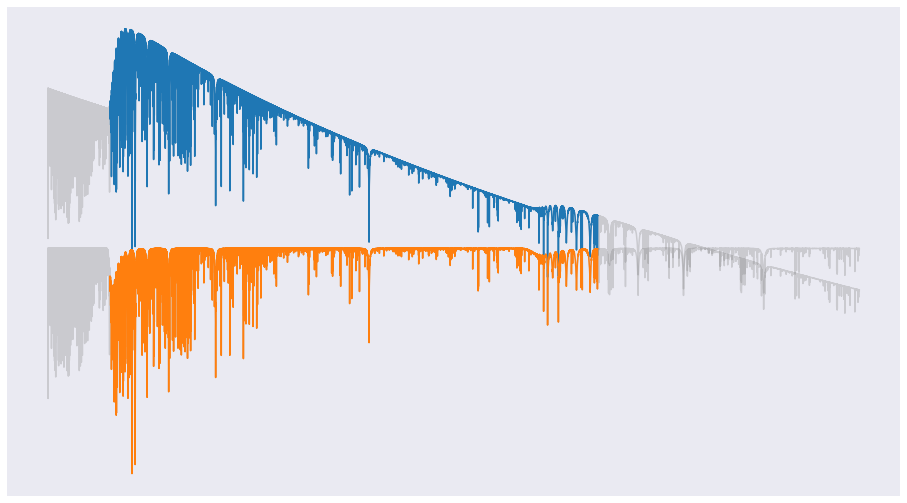

In [50]:
plt.yscale("log")
plt.xticks([]); plt.yticks([])
plt.plot(wave, flux, color="gray", alpha=0.3)
plt.plot(wave, norm*1e7, color="gray", alpha=0.3)
plt.plot(wave[ww], flux[ww])
plt.plot(wave[ww], norm[ww]*1e7)

### Minecraft

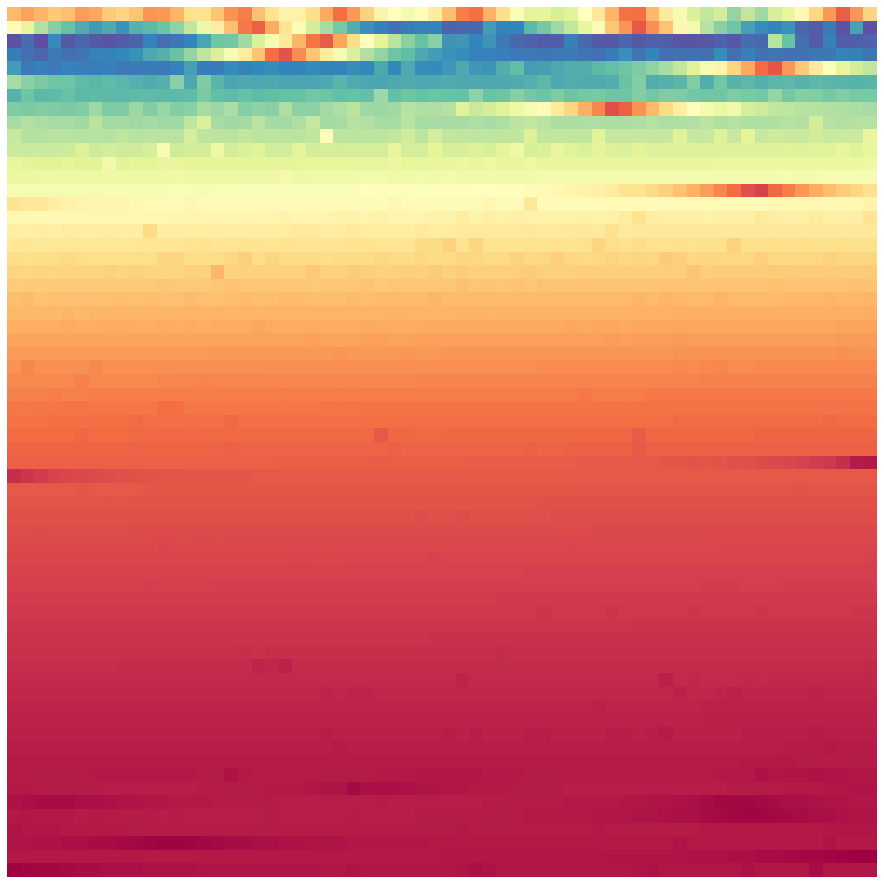

In [51]:
new = np.linspace(3690, 9100, 4096)
lux = spectres(new, wave, flux)
rob = robust_scale(lux)
sqr = spec2sqr(rob, a=64)
plt.figure(figsize=(16,16))
plt.xticks([]); plt.yticks([])
plt.imshow(sqr);

## Sampling POLLUX down to LAMOST...

```python
prog = IntProgress(min=0, max=len(data))
display(prog)
for i, name in enumerate(data["basename"]):
    if not os.path.exists(f"pollux/{name}.npy"):
        wave, flux = np.loadtxt(f"{SPECDIR}{name}.gz",
                                usecols=(0,1),
                                unpack=True)
        lux = spectres(new, wave, flux)
        rob = robust_scale(lux)
        sqr = spec2sqr(rob, a=64)
        np.save(f"pollux/{name}.npy", sqr)
        prog.value += 1
```

In [52]:
len(data)

13162

In [53]:
prog = IntProgress(min=0, max=len(data))
display(prog)
zero = np.zeros((len(data), 4096))
for i, name in enumerate(data["basename"]):
    spec = np.load(f"pollux/{name}.npy")
    zero[i,:] = spec.flatten()
    prog.value += 1
np.save("POLLUX.npy", zero)

IntProgress(value=0, max=13162)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [54]:
print("wave ~> new")

wave ~> new
